<a href="https://colab.research.google.com/github/youse0ng/pytorch_practice/blob/main/04_pytorch_custom_datasets_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 04. Pytorch Custom Datasets Video Notebook

We've used some datasets with Pytorch before.

But how do you get your own data into Pytorch?

One of the ways to do so is via : custom datasets.

## Domain libraries
Depedning on what you're working on, vision, text, audio, recommendation, you'll want to look into each of Pytorch domain libraries for existing data loading functions and customizable data loading functions

**Resources:**
* Book Version of the course materials for 04:  https://www.learnpytorch.io/04_pytorch_custom_datasets/

## 0. Importing Pytorch and setting up device-agnostic code.

In [ ]:
import torch
from torch import nn

# Note: Pytorch 1.10.0 + is required for this course
torch.__version__

In [ ]:
# Setup device - agnostic code
device="cuda" if torch.cuda.is_available() else "cpu"
device

## 1. GET Data

Our dataset is a subset of the Food101 datasets

Food101 starts 101 different classes of food and 1000 images per class (750 train images + 250 testing images)

Our dataset starts with 3 classes of food and only 10 % of the images. (~75 training images, 25 testing images)

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment


In [ ]:
import requests # URL을 다운로드하기 위해 github에서 무언가를 요청할 수 있도록 요청을 가져오는 라이브러리
import zipfile # 지금 데이터 저장 형식이 zip이니까 zip관련된 파이썬 라이브러리를 import
from pathlib import Path # 파일 경로나 디렉토리 경로를 다룰때 쓰는 라이브러

# Setup path to a data folder (데이터 폴더로 가는 경로 설정)
data_path=Path("data/")
image_path=data_path/"Pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...

if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download Pizza, steak and sushi data
with open(data_path / "Pizza_steak_sushi.zip","wb") as f:
  # https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip 이거 대신 아래 URL 사용해야함
  request =requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip pizza, steak and sushi data zip

with zipfile.ZipFile(data_path / "Pizza_steak_sushi.zip","r") as zip_ref:
  print("Unzipping pizaa, steak and sushi data...")
  zip_ref.extractall(image_path)

## 2. Becoming one with the data(data preparation and data exploration)

In [ ]:
import os

def walk_through_dir(dir_path):
  """Walk through dir_path returning its contents"""
  for dirpath, dirnames,filenames in os.walk(dir_path):
     print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")



In [ ]:
walk_through_dir(image_path)

In [ ]:
# Setup train and testing paths
train_dir=image_path /"train"
test_dir=image_path /"test"

train_dir,test_dir

### 2.1 Visualizing image

Let's write some code :

1. get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class nameusing `pathlib.Path.parent.stem`
4. Since we're working with images, Let's open the image with Python's PIL
5. We'll then show the image and print metadata

In [ ]:
image_path

In [ ]:
import random
from PIL import Image

# Set Seed
#random.seed(42)

# 1. Get all image paths
image_path_list=list(image_path.glob("*/*/*.jpg"))
# 2. Pick a random image path
random_image_path=random.choice(image_path_list)
print(random_image_path)
print(type(random_image_path))

# 3. Get image class from path name(the image class is the name of the directory where the image is stored)
image_class=random_image_path.parent.stem
print(image_class)

# 4. Open image
img=Image.open(random_image_path)

print(f'img: {img}')
# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class : {image_class}")
print(f"Image height:{img.height}")
print(f"Image width:{img.width}")
img

print(image_path_list)

In [ ]:
import glob
from pathlib import Path
image_path='Data/Training/Raw'
image_paths_list=glob.glob(image_path + '/*.jpg')
random_path=random.choice(image_paths_list)


def numpy2image(image_fn:str):
    img=Image.open(image_fn)
    img_as_array=np.asarray(img)

    plt.figure()
    plt.imshow(img_as_array)
    plt.title(f"Image shape: {img_as_array.shape} -> ['height,width,color_channels']")
    plt.axis(False)

numpy2image(random_path)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array=np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class {image_class} | Image shape: {img_as_array.shape} -> [height, width, color channels]")
plt.axis(False)

In [ ]:
img_as_array,img_as_array.shape

## 3. Transforming Data

Before we can use our image data with Pytorch:

1. Turn your target data into tensors(in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader` (세트의 반복 가능과 배치기능 버전으로 만듦)
, We'll call these `Dataset` and `DataLoader`.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation-
https://pytorch.org/vision/stable/transforms.html

In [ ]:
# Write a transform for image
# 몇 가지 변환을 함께 결합하는 방법 (Compose와 nn.Sequential을 통한 변환 결합 2가지가 있다.)
data_transform=transforms.Compose([
    # Resize our images to 64 * 64
    transforms.Resize(size=(218,218)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [ ]:
data_transform(img),data_transform(img).shape,data_transform(img).dtype

In [ ]:
image_path_list

In [ ]:
def plot_transformed_images(image_paths:list,transform,n=3,seed=None):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the originalvs the transformed vision
  """
  if seed:
    random.seed(seed)
  random_image_paths=random.sample(image_paths,k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig,ax=plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSIze:{f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image=transform(f).permute(1,2,0) # note we will need to change shape for matplotlib (지금 트랜스폼된건 (칼라채널,height,width))
      # 그래서 매트플롯립으로 바꾸어줄때 나타내게 하려면 heigth width 칼라채널로 바꾸어줘야 힌다.

      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class:{image_path.parent.stem}",fontsize=16)
plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

## 4. Option 1:Loading image data using `ImageFolder` ImageFolder 사용으로 사용자지정데이터, 사용자지정이미지를 시제로 로드하는지 보겠다.

We can load image classification data using `torchvision.datasets.ImageFolder`
-https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder

In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data=datasets.ImageFolder(root=train_dir,
                                transform=data_transform, # a transform for the data
                                target_transform=None) # a transform for the label/target
test_data=datasets.ImageFolder(root=test_dir,
                               transform=data_transform
                               )
train_data,test_data

In [ ]:
# Get class names as List
train_data.classes # Attribute 속성
class_names=train_data.classes
class_names

In [ ]:
# Get class names as dict
class_dict=train_data.class_to_idx
class_dict

In [ ]:
# Check the lengths of our dataset
len(train_data), len(test_data)

무언가를 로드하고나면 항상 Check 해보는 습관
Len()이됐든,, 사이즈 Size shape 등등

In [ ]:
train_data.samples

In [ ]:
# Index on the train_data Dataset to get a single image and label
img,label=train_data[0][0],train_data[0][1]
label
print(f"Image tensor:\n {img}")
print(f"Image shape:\n{img.shape}")
print(f"Image Datatype:\n{img.dtype}")
print(f"Image label:\n{label}")
print(f"Image datatype:\n{type(label)}")

In [ ]:
# Rearrange the order Dimensions
img_permute=img.permute(1,2,0)

# Let's check the different shape
print(f"Original Shape: {img.shape}")
print(f"Permuted Shape: {img_permute.shape}")

import matplotlib.pyplot as plt
# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(label=class_names[label])

### 4.1 Turn loaded images into `DataLoader`

A `DataLoader` is going to help us turn our dataset into Iterables and we can customize the `batch_size` so our model can see `batch_size`
images at a time

DataLoader는 데이터셋을 iterable(반복가능)(str, range, list, tuple, dict, set)오브젝트(자료형)로 바꾸어주고
Batch_size를 정하여 Batch_size만큼 이미지를 볼 수 있다.

In [ ]:
import os
os.cpu_count()

In [ ]:
# Turn train and Test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE=1

train_dataloader=DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            num_workers=os.cpu_count(), #cpu_core 개수
                            shuffle=True,
                            )
test_dataloader=DataLoader(dataset=test_data,
                           batch_size=BATCH_SIZE,
                           num_workers=os.cpu_count(),
                           shuffle=False)

train_dataloader,test_dataloader

In [ ]:
len(test_data),len(test_dataloader)

In [ ]:
len(train_dataloader),len(train_data)

In [ ]:
img,label=next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape:{img.shape} ->  [batch_size,color_channel,height,width]")
print(f"Label shape:{label.shape}")

지금 까지는 이미지 데이터 폴더에서 데이터를 가져오는 방법을 연구했다.

그리고 우리는 `ImageFolder`를 사용해서 train_data에 텐서 형식으로 넣어주었다.

그러고 나선, DataLoader를 사용해서 배치사이즈를 정하고 train_data를 Iterable할 수 있도록 만들어주었다,

하지만 `ImageFolder` 존재하지 않는다면, 사용자 지정 데이터 로딩을 어떻게 해야할까 ?

## 5 Option 2: Loading image data with a custom `Dataset`
내가 만든 Custom Dataset(로딩기능이있는)를 만들때 장단점

기능:
1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros(장점):
* Can create a `Dataset` out of almost anything (거의 모든것으로부터 데이터셋을 만들수있다.)
* Not limited to Pytorch pre-built `Dataset` functions

Cons(단점):
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues.

All Custom datasets in Pytorch, often subclass -
https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

직접 커스텀 데이터셋 (getitem과 len 길이를 반환할 커스텀 데이터셋을 만들때 참고)

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple,Dict,List

In [ ]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

### 5.1 Creating a helper functions to get class names


We want a functions to:
1. Get the class names using `os.scandir()` to traverse a target directory(ideally the directory is in standard image classification format)
지금 방식의 디렉토리 설정이 standard image classification format 형식인것 같다.
train, test 폴더 내의 클래스명의 폴더들이 들어있고 그안에 jpg가 들어가있는 형식.

2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure.)
클래스이름을 찾지 못하면 에러를 띄워야한다. 디렉토리 구조에 문제가있음을 암시해줘야함.

3. Turn the class names into a dict and list and return them

In [ ]:
# Setup path for target directory
target_directory=train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory using os.scandir
class_names_found=sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

In [ ]:
list(os.scandir(target_directory))

In [ ]:
sorted([entry.name for entry in list(os.scandir(target_directory))])

In [ ]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

In [ ]:
def find_classes(directory:str) -> Tuple[List[str],Dict[str,int]]:
  """이 함수는 바로 위에 보이는 코드의 결과값인 (['pizza','steak','sushi'],{'pizza':0,'steak':1,'sushi':2})와 같은 튜플형식을 반환하는 함수이다.
  Finds the class folder names in target directory ."""
  # 1. Get the class names by scanning the target directory
  classes= sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure")

  # 3. Create a dictionary of index labels(computers prefer numbers rather than strings as labels)
  class_to_idx={class_name:i for i,class_name in enumerate(classes)}
  return classes, class_to_idx

In [ ]:
find_classes(target_directory)

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

제일 중요한 것 같다 이번 파트에서

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data
대상 디렉토리로 서브클래스를 초기화한다.(우리가 디렉토리로 부터 데이터를 갖고오고 싶은 디렉토리) 또한 변환도 초기화 해야한다.

3. Create several attribute:
* Paths - paths of our images
* transform - the transform we'd like to use
* classes - a list of thje target classes (타겟명)
* class_to_idx - a dict of the target classes mapped to integer labels

4. Create a function to `load images()`, this fuction will open an image

5. Overwrite the `__len()__` method to return the length of our datasets

6. Overwrite the `__getitem()__` method to return a given sample when passed an index (인덱스를 전달할때 주어진 인덱스에 맞는 sample data를 반환하는 method)

In [ ]:
# Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize Our custom Dataset
  def __init__(self, targ_dir:str, transform=None):
    # 3. Create class attributes
    # Get all of the image paths
    self.paths=list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx=find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index:int) ->Image.Image:
    "Opens an image via a path and returns it."
    image_path=self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite the __len()__ method to return the length of our datasets
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)

  # 6. Overwrite __getitem()__ method to return a particular sample
  def __getitem__(self,index:int) -> Tuple[torch.Tensor,int]:
    "Returns one sample of data, data and label (X,y)."
    img= self.load_image(index)
    class_name=self.paths[index].parent.name # Expects path in format:data_folder/class_name/image.jpg
    class_idx=self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:# 트랜스폼이 존재한다면,
      return self.transform(img),class_idx # return Data, label : (X,y)
    else:
      return img,class_idx # return untransformed image and label

In [ ]:
# Create a transform
from torchvision import transforms
train_transforms= transforms.Compose([transforms.Resize(size=(64,64)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor()
                                      ])
test_transforms= transforms.Compose([transforms.Resize(size=(64,64)),
                                     transforms.ToTensor()
                                     ])

In [ ]:
# Test out ImageFOlderCustom
train_data_custom=ImageFolderCustom(targ_dir=train_dir,
                                    transform=train_transforms)
test_data_custom=ImageFolderCustom(targ_dir=test_dir,
                                   transform=test_transforms)

In [ ]:
len(train_data), len(train_data_custom)

In [ ]:
len(test_data), len(test_data_custom)

In [ ]:
train_data_custom.classes

In [ ]:
train_data_custom.class_to_idx

In [ ]:
len(train_data_custom.paths)

In [ ]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustomDataset
# 이미지폴더 데이터셋과 내가만든 사용자지정 커스텀이미지폴더 데이터셋과 얼마나 유사한지 체크

print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters
such as class names and how many images to visualize
2. To prevent the display getting out of hand, let's cap the number of images to see at 10. (10개 까지만 본다)
3. Set the random seed for reproductibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample indexes and plot them with matplotlib.
7. Make sure the dimensions of our images line up with Matplotlib(HWC)

In [ ]:
# 1. Create a function to take in a dataset.
def display_random_images(dataset:torch.utils.data.Dataset,
                          classes:List[str]=None,
                          n: int=10,
                          display_shape:bool=True,
                          seed:int=None):
  # 2. Adjust display if n is too high
  if n>10:
    n=10
    display_shape=False
    print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx=random.sample(range(len(dataset)),k=n)

  # 5. Setup plot
  plt.figure(figsize=(20,10))

  # 6. Loop through random indexes and plot them with matplotlib
  for i,targ_sample in enumerate(random_samples_idx):
    targ_image,targ_label=dataset[targ_sample][0],dataset[targ_sample][1]

  # 7. Adjust tensor dimensions for plotting
    targ_image_adjust=targ_image.permute(1,2,0) #[color_channel,height,width] -> [height,width,color_channels]

  # Plot adjusted sample
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title=f"Class:{classes[targ_label]}"
      if display_shape:
        title=title+f"\n shape :{targ_image_adjust.shape}"
    plt.title(title)

In [ ]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

In [ ]:
# Display random images from the ImageFolderCustom Dataset.

display_random_images(train_data_custom,
                      n=10,
                      classes=class_names,
                      seed=42)

In [ ]:
### 5.4 Turn custom loaded images into `DataLoader`
BATCH_SIZE=32
from torch.utils.data import DataLoader
train_custom_dataloader=DataLoader(dataset=train_data_custom,
                                   batch_size=BATCH_SIZE,
                                   num_workers=0,
                                   shuffle=True)
test_custom_dataloader=DataLoader(dataset=test_data_custom,
                                  batch_size=BATCH_SIZE,
                                  num_workers=os.cpu_count(),
                                  shuffle=False)
train_custom_dataloader,test_custom_dataloader

In [ ]:
train_custom_dataloader,test_custom_dataloader
next(iter(train_custom_dataloader))

In [ ]:
# Get image and label from custom dataloader
img_custom,label_custom=next(iter(train_custom_dataloader))

# Print out the shapes
img_custom.shape,label_custom.shape

Image Transforming and Augmentation:
1. Resize
2. CenterCrop
3. Grayscale
4. RandomTransform
5. GaussianBlur
6. RandomRotation
7. RandomAffine
8. RandomCrop
9. Auto Augment
10. Rand Augment

http://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

## 6. Other forms of Transform (data augmentation)

Data augmentation is the process of articially adding diversity to your training data.
데이터 오그맨테이션은 훈련 데이터에 인위적으로 다양성을 추가하는 과정이다.

In the case of image data, this may mean applying various image transformation to the training images.
이미지 데이터의 경우엔, 데이터 오그맨테이션이 다양한 이미지 변환을 훈련이미지에 적용시키는 것을 의미할 지도 모른다.

This practice hopefully results in a model that's more generalizable to unseen data.
이 방법은 모델이 보지않았던 데이터에 대해 더욱 일반화할 수 있는 모델을 야기한다.

Let's take a look at one particular type of data augmentation used to train Pytorch vision models to state of the art levels...
- https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#break-down-of-key-accuracy-improvements

Augmentation의 최신 기술 중 하나인:
Trivialaugment

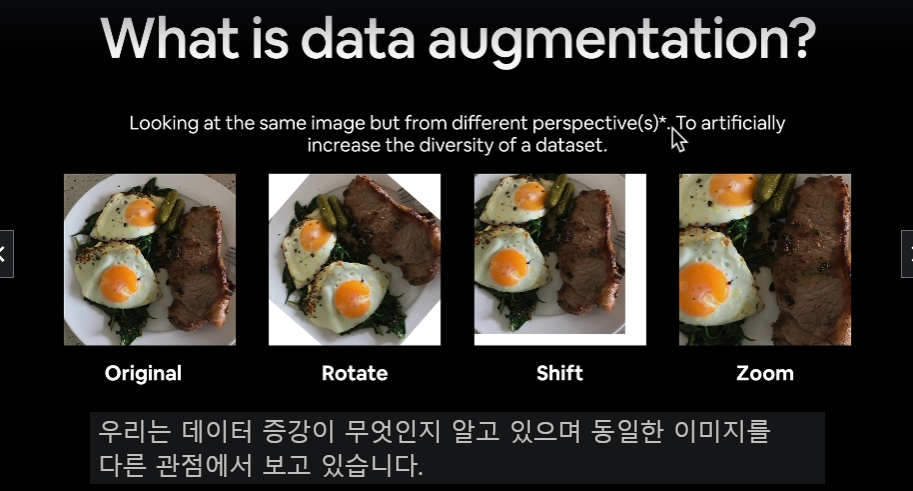

In [ ]:
# Let's look at trivialaugment - http://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
from torchvision import transforms
train_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=5), # 강도 조절
    transforms.ToTensor()
])

test_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [ ]:
# Get all image paths
image_path_list=list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

In [ ]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation

Let's replicate TinyVGG architecture from the CNN Explainer Website: https://poloclub.github.io/cnn-explainer/


### 7.1 Creating transforms and loading data for Model 0

In [ ]:
# Create simple transform
simple_transform=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [ ]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple=datasets.ImageFolder(root=train_dir,
                                       transform=simple_transform
                                       )
test_data_simple=datasets.ImageFolder(root=test_dir,
                                      transform=simple_transform
                                      )

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch_size and number of workers
BATCH_SIZE=32
NUMBER_OF_WORKERS=os.cpu_count()

# Create Dataloader's
train_dataloader_simple=DataLoader(dataset=train_data_simple,
                                   batch_size=BATCH_SIZE,
                                   shuffle=True,
                                   num_workers=NUMBER_OF_WORKERS)
test_dataloader_simple=DataLoader(dataset=test_data_simple,
                                   batch_size=BATCH_SIZE,
                                   shuffle=False,
                                   num_workers=NUMBER_OF_WORKERS)


In [ ]:
train_dataloader_simple

In [ ]:
NUMBER_OF_WORKERS

### 7.2 Create a TinyVGG Model class

In [ ]:
class TinyVGGModel(nn.Module):
  def __init__(self,input_shape:int,output_shape:int,hidden_units:int) -> None:
    super().__init__()
    self.block_1=nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=(3,3),
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=(3,3),
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2),
                     stride=2)
    )
    self.block_2=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=(3,3),
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=(3,3),
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2),
                     stride=2)
    )
    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 13 * 13,
                  out_features=output_shape)
    )
  def forward(self,x):
    x=self.block_1(x)
    #print(x.shape)
    x=self.block_2(x)
    #print(x.shape)
    x=self.classifier(x)
    #print(x.shape)
    return x
    # shape가 어떻게 블록을 통과할때 마다 unit이 어떻게 변경되는지 보기위해 print(x.shape)를 출력한다.
    # return (classifier(self.block_2(self.block_2(x)))) benefits from operator fusion (more Speed up computation)
    #-https://cdn.danielbmarkham.com/reference/original-articles/nerd-roundup/2022-03-18/MakeDeepLearningGoBrrrUsingFirstPrinciples.html#:~:text=Making%20Deep%20Learning%20Go%20Brrrr%20From%20First%20Principles,to%20None%21%20Install%20PyTorch%201.10.0%20but%20not%201.10.1%21%22

In [ ]:
torch.manual_seed(42)
model_0=TinyVGGModel(input_shape=3,# number of color channels in our image data)
                      hidden_units=10,
                      output_shape=len(class_names)).to(device)
model_0

### 7.3 Try a forward pass on a single image (to test model)

In [ ]:
# Get a single image batch
image_batch, label_batch=next(iter(train_dataloader_simple))
image_batch.shape,label_batch.shape

In [ ]:
16*16*10

In [ ]:
# Try a forward pass
model_0(image_batch)

### 7.4 Use `torchinfo` to get an idea of the shpaes going through our model
`torchinfo`를 사용해서 모델을 통과하는 모양에 대한 생각을 얻는다.

In [ ]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0,input_size=[1,3,64,64])

### 7.5 Create our train and test loops functions

*`train_step()` - takes in a model and dataloader and trains the model on the dataloader.

*`test_step()` -takes in a model and dataloader and evaluates the model on the dataloader


In [ ]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss,train_acc=0,0

  # Loop through data loader data batches
  for batch,(X,y) in enumerate(dataloader):
    # Send data to the target device
    X,y= X.to(device),y.to(device)

    # 1. Forward pass
    y_pred=model_0(X) # output model logits

    # 2. Calculate Loss
    loss=loss_fn(y_pred,y)
    train_loss+=loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    # Calculate the accuracy metrics
    y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc+=(y_pred_class==y).sum().item()/len(y_pred)
  # Adjusting metrics to get average loss and accuracy per batch
  train_loss=train_loss/len(dataloader)
  train_acc=train_acc/len(dataloader)
  return train_loss,train_acc

In [ ]:
# Create a test step
def test_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test acc values
  test_loss,test_acc=0,0
  # turn on inference mode
  with torch.inference_mode():
    #Loop through Dataloader batches
    for batch,(X,y) in enumerate(dataloader):
      # Send data to the taget device
      X,y=X.to(device),y.to(device)

      # 1. Forward pass
      test_pred_logits=model(X)

      # 2. Calculate loss
      loss=loss_fn(test_pred_logits,y)
      test_loss+=loss.item()

      # Calculate the acc
      test_pred_labels=test_pred_logits.argmax(dim=1)
      test_acc+=((test_pred_labels==y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss=test_loss/len(dataloader)
  test_acc=test_acc/len(dataloader)
  return test_loss,test_acc

In [ ]:
from torch import nn
from torch import optim
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.SGD(params=model_0.parameters(),lr=0.1)

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [ ]:
# 내가 만든 train 기능
#from tqdm import tqdm
#epochs=3
#for epoch in tqdm(range(epochs)):
#  train_step(model=model_0,
#            dataloader=train_dataloader_simple,
#             loss_fn=loss_fn,
#            optimizer=optimizer,
#           device=device
#          )
#  test_step(model=model_0,
 #           dataloader=test_dataloader_simple,
  #          loss_fn=loss_fn,
   #         device=device)
  #print(f"test_loss and test_acc {test_step}")
#  print(f"train_loss and train_acc {train_step}")

In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### 7.7 Train and evaluate model 0

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS=20

 # Recreate an instance of TinyVGG
model_0=TinyVGGModel(input_shape=3, # number of color channels of our target images
                       hidden_units=10,
                       output_shape=len(train_data.classes)).to(device)
# Setup loss function and optimizer
loss_fn= nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_0.parameters(),
                           lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time=timer()

# Train model_0
model_0_results=train(model=model_0,
                      train_dataloader=train_dataloader_simple,
                      test_dataloader=test_dataloader_simple,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time=timer()
print(f"Total training time:{end_time-start_time:.3f} seconds")

In [ ]:
model_0_results

### 7.8 Plot the loss curves of model_0

A **loss curve** is a way of tracking your model's progress over time
로스 커브는 시간에따라 모델의 진행상황을 추적하는 방법이다.

a good guide for different loss curves can be see here:https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic?hl=ko

In [ ]:
# Get the model_0_results keys
model_0_results.keys()

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [ ]:
model_0_results

In [ ]:
plot_loss_curves(model_0_results)

UnderFit한 모습을 보이는 Loss Curves

Loss Curves 에 대한 해석

https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic?hl=ko

## 8. What should an ideal loss curve look like?
https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic?hl=ko

A loss curve is one of the most helpful ways to troubleshoot a model.

HOW TO DEAL WITH OVERFITTING - https://www.learnpytorch.io/04_pytorch_custom_datasets/#81-how-to-deal-with-overfitting
HOW TO DEAL WITH UNDERFITTING - https://www.learnpytorch.io/04_pytorch_custom_datasets/#82-how-to-deal-with-underfitting

## 9. Model 1 : TinyVGG With Data Augmentation

Now let's try another modelling experiment this time using the same model as before with some data augmentation

### 9.1  Create transform with data Augmentation

In [ ]:
# Create training transform with TrivialAugment
from torchvision import transforms
train_transform_trivial=transforms.Compose([transforms.Resize(size=(64,64)),
                                            transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                            transforms.ToTensor()
                                            ])

test_transform_simple=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

### 9.2 Create train and test `Dataset`'s and `DataLoader`'s with data augmentation

In [ ]:
# Turn iamge folders into Dataset
from torchvision import datasets
train_data_augmented=datasets.ImageFolder(root=train_dir,
                                          transform=train_transform_trivial,
                                          )
test_data_simple=datasets.ImageFolder(root=test_dir,
                                         transform=test_transform_simple)

In [ ]:
BATCH_SIZE=32
import os
from torch.utils.data import DataLoader
train_dataloader_augmented=DataLoader(dataset=train_data_augmented,
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      num_workers=os.cpu_count()
                                      )
test_dataloader_simple=DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     num_workers=os.cpu_count()
                                     )

### 9.3 Construct and train model 1

this time we'll be using the same model architecture except this time we've augmented the training data

In [ ]:
len(train_data_augmented.classes)

In [ ]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1=TinyVGGModel(input_shape=3,
                     output_shape=len(train_data_augmented.classes),
                     hidden_units=10).to(device)
model_1

In [ ]:
from torchinfo import summary
summary(model=model_1,input_size=(1,3,64,64))

Now we've created a model and dataloaders, let's create loss function and opitimizer and call upon our `train()` function to train and evaluate our model.


In [ ]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS=5

# Setup loss function
loss_fn=nn.CrossEntropyLoss()

# Setup optimizer
optimizer=torch.optim.Adam(params=model_1.parameters(),
                           lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time=timer()

# Train model_1
model_1_results=train(epochs=NUM_EPOCHS,
                      model=model_1,
                      train_dataloader=train_dataloader_augmented,
                      test_dataloader=test_dataloader_simple,
                      optimizer=optimizer)

# End the timer and print out how long it took
end_time=timer()
print(f"Total training time for model : {end_time-start_time:.3f} seconds")


In [ ]:
plot_loss_curves(model_1_results)

## 10. Compare model results

After evaluating our modelling experiments on their own, it's important to compare them to each other.

모델실험을 평가할때 툴들

There's a few different ways to do this:
1. Hard coding (what we're doing)
2. PyTorch + TensorBoard - https://pytorch.org/docs/stable/tensorboard.html
3. Weights and Biases - https://wandb.ai/site/experiment-tracking  (WandB)
4. MLFlow - https://mlflow.org/

In [ ]:
import pandas as pd
model_0_df=pd.DataFrame(model_0_results)
model_1_df=pd.DataFrame(model_1_results)
model_0_df

In [ ]:
# Setup plot
plt.figure(figsize=(15,10))

# Get number of epochs
epochs=range(len(model_0_df))
epochs

# Plot train loss
plt.subplot(2,2,1)
plt.plot(epochs,model_0_df["train_loss"],label="model 0 without Data Augmentation")
plt.plot(epochs, model_1_df["train_loss"],label="model 1 with Data Augmentation")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2,2,2)
plt.plot(epochs,model_0_df["test_loss"],label="model 0 without Data Augmentation")
plt.plot(epochs, model_1_df["test_loss"],label="model 1 with Data Augmentation")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot Train acc
plt.subplot(2,2,3)
plt.plot(epochs,model_0_df["train_acc"],label="model 0 without Data Augmentation")
plt.plot(epochs, model_1_df["train_acc"],label="model 1 with Data Augmentation")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()

# Plot test acc
plt.subplot(2,2,4)
plt.plot(epochs,model_0_df["test_acc"],label="model 0 without Data Augmentation")
plt.plot(epochs, model_1_df["test_acc"],label="model 1 with Data Augmentation")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend()

## 11. Making a prediction on a custom image

Although we've trained a model on custom data... how do you make a prediction on a sample/image that's not in either training or testing datasets.

  

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path=data_path/"04-pizza-dat.jpeg"

# Download the image if it doesn't already exist.
if not custom_image_path.is_file():
  with open(custom_image_path,"wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg?raw=true")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")


### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor from with datatype(torch.float32)
* Of shape 64*64*3
* On the right device

In [ ]:
import torchvision
import matplotlib.pyplot as plt
# Read in custom image
custom_image_uint8=torchvision.io.read_image(str(custom_image_path))
custom_image_uint8

plt.imshow(custom_image_uint8.permute(1,2,0))
plt.axis(False)

print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

### 11.2 Making a prediction on a custom image with PyTorch Model



In [ ]:
img

In [ ]:
# Load in the custom image and convert to torch.float32
custom_image=torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255. # img와는 다르게 datatype이 int이므로 255.으로 나누어
custom_image

In [ ]:
plt.imshow(custom_image.permute(1,2,0))

In [ ]:
# Try to make a prediction on an image in uint8 format
model_1.eval()
with torch.inference_mode():
  model_1(custom_image.to(device))

In [ ]:
# Create transform pipeline to resize image
from torchvision import transforms
custom_image_transform=transforms.Compose([
    transforms.Resize(size=(64,64))
])

# Transform target image
custom_image_transformed=custom_image_transform(custom_image)

# Print out the shape
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape : {custom_image_transformed.shape}")

plt.imshow(custom_image_transformed.permute(1,2,0))

In [ ]:
# This will error:no batch size
model_1.eval()
with torch.inference_mode():
  custom_image_pred=model_1(custom_image_transformed.to(device))

In [ ]:
custom_image_transformed.unsqueeze(dim=0).shape

In [ ]:
# This should this work? (added a batch_size)
model_1.eval()
with torch.inference_mode():
  custom_image_pred=model_1(custom_image_transformed.unsqueeze(dim=0).to(device))
custom_image_pred

In [ ]:
custom_image_pred.shape

Note, to make a prediction on a custom image we had to:
* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model(torch.float32)
* Make sure the image was the same shape as the data the model was trained on (3x64x64) with a batch size(1,3,64,64)
* Make sure the image was on the same device as our model


In [ ]:
# Convert logits -> prediction probabilities
custom_image_pred_probs=torch.softmax(custom_image_pred,dim=1)
custom_image_pred_probs # 별로 좋지않은 성능 그이유는, 각각의 확률이 비슷함..

In [ ]:
# Convert prediction probabilities -> prediction labels
custom_image_pred_label=torch.argmax(custom_image_pred_probs,dim=1)
custom_image_pred_label

In [ ]:
class_names[custom_image_pred_label]

### 11.3 Putting custom Image prediction together: building a function

ideal outcome:

A function where we pass an image path to and have our model predict on that image and plot image prediction.

In [ ]:
# Function # 내가 만든 function

import torchvision
import matplotlib.pyplot as plt
def plot_custom_image_prediction(target_path:str,
                                 model:torch.nn.Module,
                                 transform:torchvision.transforms.Compose,
                                 class_names=class_names
                                 ):
  custom_image_format_uint8_to_float32=(torchvision.io.read_image(str(target_path))/255).type(torch.float32)
  custom_transformed_image=transform(custom_image_format_uint8_to_float32)
  model.eval()
  with torch.inference_mode():
    custom_image_pred=model(custom_transformed_image.unsqueeze(dim=0))
  custom_image_pred_probs=torch.softmax(custom_image_pred,dim=1)
  custom_image_pred_label=torch.argmax(custom_image_pred_probs,dim=1)
  plt.imshow(custom_transformed_image.permute(1,2,0))
  plt.title(label=class_names[custom_image_pred_label])
  plt.axis(False)
  print(f"This is custom_image_pred_probs : {custom_image_pred_probs}")
  print(f"This is custom_image_pred_label : {custom_image_pred_label}")

In [ ]:
plot_custom_image_prediction(target_path="/content/data/sushi.jpg",
                             model=model_1,
                             transform=custom_image_transform,
                             class_names=class_names)

In [ ]:
def pred_and_plot_image(model:torch.nn.Module,
                        image_path:str,
                        class_names:List[str]=None,
                        transform=None,
                        device=device):
  """Make a prediction on a target image with a trained model and plots the image and prediction."""
  # Load in the image
  target_image=torchvision.io.read_image(str(image_path))